In [19]:

import matplotlib.pyplot as plt
import numpy as np
import obspy.taup as taup
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mod_ak135 = taup.TauPyModel('ak135')

In [4]:
phase = 'ScS'*20
tmp = [mod_ak135.get_travel_times(0.0, it, [phase]) for it in np.arange(0, 180.5, 0.5)]
arrs = [it for v in tmp for it in v ]

In [20]:
rps = np.array( [it.ray_param_sec_degree for it in arrs] )
dist = np.array( [it.distance for it in arrs] )
purist_distance = np.array( [it.purist_distance for it in arrs] )
travt = np.array( [it.time for it in arrs] )

idx = np.argsort(rps)
rps = rps[idx]
dist = dist[idx]
purist_distance = purist_distance[idx]
travt = travt[idx]

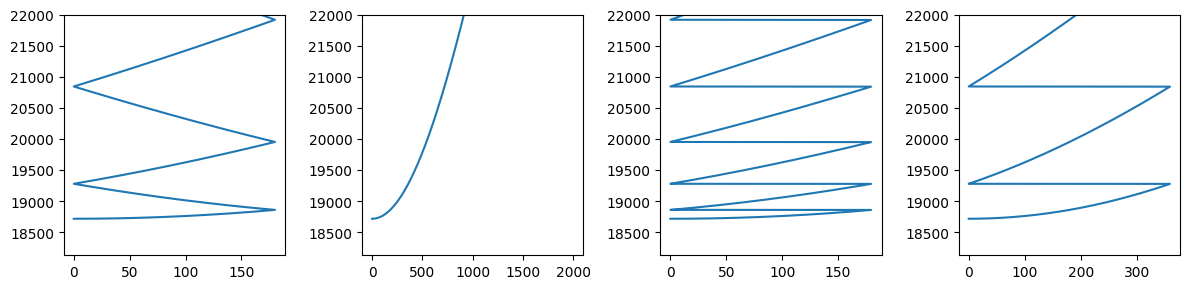

In [31]:
fig, axlst = plt.subplots(1, 4, figsize=(12, 3))
ax1, ax2, ax3, ax4 = axlst

ax1.plot(dist, travt)
ax2.plot(purist_distance, travt)
ax3.plot(purist_distance%180.0, travt)
ax4.plot(purist_distance%360.0, travt)
for ax in axlst:
    ax.set_ylim(top=22000)
plt.tight_layout()

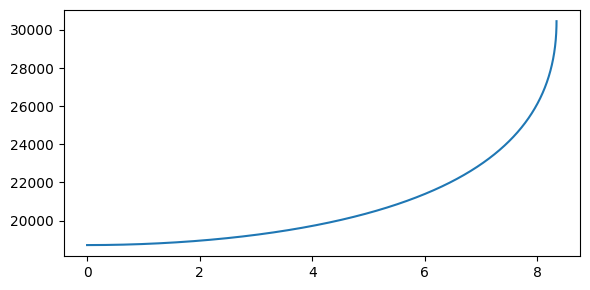

In [35]:
fig, axlst = plt.subplots(1, 1, figsize=(6, 3))
ax1 = axlst

ax1.plot(rps, travt)
plt.tight_layout()

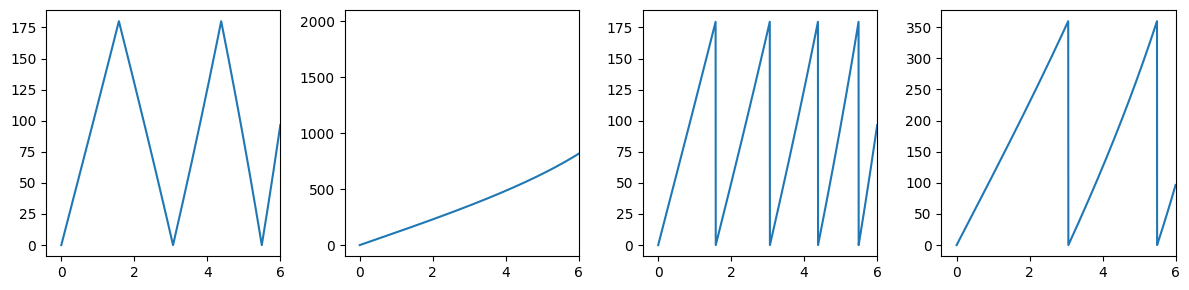

In [39]:
fig, axlst = plt.subplots(1, 4, figsize=(12, 3))
ax1, ax2, ax3, ax4 = axlst

ax1.plot(rps, dist)
ax2.plot(rps, purist_distance)
ax3.plot(rps, purist_distance%180)
ax4.plot(rps, purist_distance%360)
for ax in axlst:
    ax.set_xlim(right=6)
plt.tight_layout()

In [188]:
from numpy import arange, array, linspace, interp, argsort, argmin, deg2rad, column_stack
from time import time as compute_time
import sacpy
import os.path
from sacpy.taupplotlib import plotPrettyEarth, plotStation, plotEq
import pickle

class cc_feature_time:
    def __init__(self, model_name='ak135'):
        self.mod = taup.TauPyModel(model_name)
        self.time_get_dist_rayparam_time = 0.0
        pass
    def get_rp_dist_time(self, phase, dist_start=0.0, dist_end=180.0, dist_step=0.5, evdp_km= 0.0):
        """
        """
        ttmp = compute_time()
        ###
        filename = '%s/bin/dataset/cc_feature_time.pkl' % sacpy.__path__[0]
        evdp_meter = int(evdp_km*1000)
        search_key = (phase, evdp_meter)
        vol = dict()
        if os.path.exists(filename):
            with open(filename, 'rb') as fid:
                vol = pickle.load(fid)
        if search_key not in vol:
            tmp  = [self.mod.get_travel_times(evdp_km, it, [phase]) for it in arange(dist_start, dist_end+dist_step, dist_step)]
            arrs = [it for sub in tmp for it in sub]
            rp          = array( [it.ray_param_sec_degree for it in arrs] )
            purist_dist = array( [it.purist_distance for it in arrs] ) # purist_distance other than actual distance
            dist        = array( [it.distance for it in arrs] )
            time        = array( [it.time for it in arrs] )
            # sort
            idx = argsort(rp)
            rp          = rp[idx]
            purist_dist = purist_dist[idx]
            dist        = dist[idx]
            time        = time[idx]
            vol[search_key] = { 'purist_dist': purist_dist, 'dist': dist, 'rp': rp, 'time': time }
            with open(filename, 'wb') as fid:
                pickle.dump(vol, fid)###
        ###
        self.time_get_dist_rayparam_time  = self.time_get_dist_rayparam_time  + (compute_time() - ttmp)
        return vol[search_key]
    def search_inter_rcv(self, inter_rcv_dist, phase1, phase2, evdp_km, show=False, figname= None, accuracy_degree=0.1):
        ##############################################################################################################
        #  Get rp-dist-time data for the two seismic phases
        ##############################################################################################################
        vol1 = self.get_rp_dist_time(phase1, evdp_km=evdp_km)
        vol2 = self.get_rp_dist_time(phase2, evdp_km=evdp_km)
        rp1, pd1, dist1, t1 = vol1['rp'], vol1['purist_dist'], vol1['dist'], vol1['time'] # d1 is betwewen 0 and 360
        rp2, pd2, dist2, t2 = vol2['rp'], vol2['purist_dist'], vol2['dist'], vol2['time'] # d2 ...
        ##############################################################################################################
        #  We set two receivers r1 and r2, and we emmit two seismic waves of the same slowness rp from the receivers.
        #  The waves will travel purist distance pd1 and pd2, and the waves will arrive at the r1+pd1 and r2+pd2
        #  that are the locations of the two sources. s1=r1+pd1, s2=r2+pd2
        #
        #  If s1 equals to s2 (s1-s2=0), or (s1-s2)%360=0, then the sources are at the same location. In that way,
        #  we find the slowness rp, the purist distances, and the location of the same source.
        ##############################################################################################################
        rp_min = max(rp1.min(), rp2.min() )
        rp_max = min(rp1.max(), rp2.max() )
        denser_rp  = linspace(rp_min, rp_max, int(1440/accuracy_degree)+1)
        denser_pd1 = interp(denser_rp, rp1, pd1)
        denser_pd2 = interp(denser_rp, rp2, pd2)
        sta_loc_pair= ( (0.0, inter_rcv_dist), (inter_rcv_dist, 0.0) ) # rotate between the two receivers
        found = list()
        for r1, r2 in sta_loc_pair:
            s1 = r1+denser_pd1
            s2 = r2+denser_pd2
            diff = s1-s2
            for n_overlap in np.arange(diff.min()//360, diff.max()//360 + 1 ):
                relative_diff = diff - n_overlap*360 # look for diff across 0 degree or multiple of 360 degree
                product = relative_diff[:-1]*relative_diff[1:]
                idx = np.where(product<=0.0)[0]
                if idx.size > 0:
                    found.extend( [(r1, r2, s_found, rp_found, n_overlap) for (s_found, rp_found) in zip(s1[idx], denser_rp[idx]) ] )
        found = np.array(found)
        rps = found[:,3]
        t1_found = interp(rps, rp1, t1)
        t2_found = interp(rps, rp2, t2)
        ct_found = t1_found-t2_found
        found = column_stack( [ found, t1_found, t2_found, ct_found ] )
        # sort with respect to rp
        rp_found = found[:,3]
        idx = argsort(rp_found)
        found = found[idx]
        ##############################################################################################################
        # Print the result
        ##############################################################################################################
        print('#cross-term inter-dist(deg)  dist1(deg)  dist2(deg)  ray_param(s/deg)  t1(s)  t2(s)  cc_time(s)')
        for row in found:
            r1, r2, s, rp, n_overlap, t1, t2, ct = row
            print('%s-%s %6.2f %7.2f %7.2f %7.2f %9.2f %9.2f %9.2f' % (phase1, phase2, inter_rcv_dist, s-r1, s-r2, rp, t1, t2, ct) )
        ##############################################################################################################
        # Optional plot
        ##############################################################################################################
        if show or figname:
            self.plot(found, rp1, rp2, pd1, pd2, phase1, phase2)
    def plot(self, found, rp1, rp2, pd1, pd2, phase1, phase2, show=False, figname=None):
        """
        """
       
        ##############################################################################################################
        # Init axes
        ##############################################################################################################
        nsol = len(found)
        fig = plt.figure(figsize=(11, 4*nsol) )
        axmat = [[None, None] for junk in range(nsol)]
        for isol in range(nsol):
            axmat[isol][0] = plt.subplot(nsol, 2, isol*2+1, projection='polar')
            axmat[isol][1] = plt.subplot(nsol, 2, isol*2+2)
        #fig, axmat = plt.subplots(nsol, 2, figsize=(nsol*5.5, 8) )
        radius = self.mod.model.radius_of_planet
        for (ax1, ax2), it_found in zip(axmat, found):
            r1, r2, s_found, rp_found, n_overlap, t1_found, t1_found, ct_found = it_found
            clrs, lss = ('C0', 'k'), ('-', '--')
            ##############################################################################################################
            # Plot ray paths
            ##############################################################################################################
            for rcv, clr, ls, phase in zip((r1, r2), clrs, lss, (phase1, phase2)):
                plotStation(ax1, self.mod, (0.0,), (rcv,), clr)
                arrs = self.mod.get_ray_paths(0.0, s_found-rcv, [phase])
                idx = argmin( [abs(it.ray_param_sec_degree-rp_found) for it in arrs] )
                arr = arrs[idx]
                lons = arr.path['dist'] + deg2rad(rcv)
                rs   = radius-arr.path['depth']
                ax1.plot(lons, rs, color=clr, linestyle=ls)
            plotEq(ax1, self.mod, (0.0,), (s_found,), markersize=16)
            plotPrettyEarth(ax1, self.mod, True, 'core')
            ##############################################################################################################
            # Plot ray_param versus src_loc curves for the two seismic waves to show the intersection, the found source
            ##############################################################################################################
            s1 = r1+pd1
            s2 = r2+pd2+n_overlap*360
            for _rp, _s, clr, ls, phase in zip( (rp1, rp2), (s1, s2), clrs, lss, (phase1, phase2) ):
                ax2.plot(_rp, _s, label=phase, color=clr, linestyle=ls)
            ax2.plot(rp_found, s_found, 'o', color='k')
            #
            rp_min = min(rp1.min(), rp2.min() )
            rp_max = max(rp1.max(), rp2.max() )
            s_min = min(s1.min(), s2.min() )
            s_max = max(s1.max(), s2.max() )
            s_min = s_min - 0.1*(s_max-s_min)
            s_max = s_max + 0.1*(s_max-s_min)
            ax2.plot((rp_min, rp_max), (s_found, s_found), 'k:', linewidth=0.6)
            s_found_valid = s_found%360
            if s_found == s_found_valid:
                ax2.text(0, s_found, '%.2f$\degree$' % s_found  )
            else:
                ax2.text(0, s_found, '%.2f$\degree$(%.2f$\degree$)' % (s_found_valid, s_found) )
            #
            ax2.plot((rp_found, rp_found), (s_min, s_max), 'k:', linewidth=0.6)
            ax2.text(rp_found, s_min, '%.2f$\degree$/s' % rp_found  )
            #
            ax2.text(rp_min, s_min, '$T_{cc}=$%.2fsec' % ct_found )
            #
            ax2.set_xlim(left=0.0)
            ax2.set_ylim((s_min, s_max) )
            ax2.set_xlabel('Ray parameter (s/$\degree$)')
            yticks = ax2.get_yticks()
            ax2.set_yticks(yticks)
            ax2.set_yticklabels( [ '%03d %03d' % (it, it%360) for it in yticks] )
            ax2.set_ylabel('Source location ($\degree$)')
        axmat[0][1].legend(loc=(0.0, 1.01) )
        if figname!=None:
            plt.savefig(figname, bbox_inches = 'tight', pad_inches = 0.2)
        if show:
            plt.show()
        plt.close()

app = cc_feature_time()
app.search_inter_rcv(170, 'ScS'*10, 'ScS', 10.0, show=True)

#cross-term inter-dist(deg)  dist1(deg)  dist2(deg)  ray_param(s/deg)  t1(s)  t2(s)  cc_time(s)
ScSScSScSScSScSScSScSScSScSScS-ScS 170.00  188.86   18.86    3.20   9663.70    963.76   8699.94
ScSScSScSScSScSScSScSScSScSScS-ScS 170.00  211.07  381.07    3.54   9738.58    971.24   8767.33
ScSScSScSScSScSScSScSScSScSScS-ScS 170.00  588.86  418.86    7.38  11916.14   1188.95  10727.19
ScSScSScSScSScSScSScSScSScSScS-ScS 170.00  611.08  781.08    7.50  12081.42   1205.47  10875.95
ScSScSScSScSScSScSScSScSScSScS-ScS 170.00  988.25  818.25    8.34  15127.57   1510.26  13617.31


phase ray_param range: 0 110.25383284885037
0.0 PKIKP phase arrival at 1198.649 seconds
12.250425872094485 PKIKP phase arrival at 1198.252 seconds
24.50085174418897 PKIKP phase arrival at 1197.056 seconds
36.75127761628346 PKIKP phase arrival at 1195.037 seconds
49.00170348837794 PKIKP phase arrival at 1192.174 seconds
61.25212936047242 PKIKP phase arrival at 1188.361 seconds
73.50255523256692 PKIKP phase arrival at 1183.372 seconds
85.7529811046614 PKIKP phase arrival at 1176.640 seconds
98.00340697675588 PKIKP phase arrival at 1166.347 seconds
110.25383284885037 PKIKP phase arrival at 1109.503 seconds


/tmp/ipykernel_1381559/4103881386.py:34: ObsPyDeprecationWarning: The plot() function is deprecated. Please use arrivals.plot_rays()
  arrs.plot()


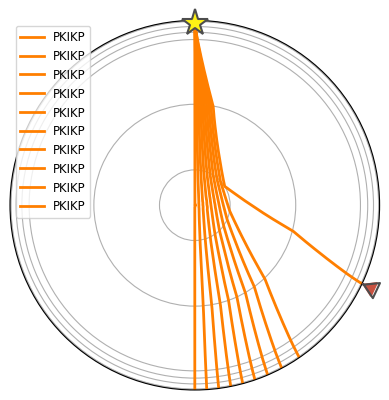

<PolarAxesSubplot:>

In [13]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
import obspy.taup as taup
from obspy.taup.seismic_phase import SeismicPhase
from obspy.taup.tau import Arrivals


evdp_km = 100
rcvdp_km = 0.1
phase = 'PKIKP'
# 1. correct for evdp and rcvdp
tau_model = mod.model
tau_model_depth_corrected = tau_model.depth_correct(evdp_km)
tau_model_depth_corrected.split_branch(rcvdp_km)

# 2. create a seismic phase
phase = SeismicPhase(phase, tau_model_depth_corrected, rcvdp_km)
print('phase ray_param range:', phase.min_ray_param, phase.max_ray_param)

arrs = list()
for ray_param in np.linspace(phase.min_ray_param, phase.max_ray_param, 100):
    arr = phase.shoot_ray(0.0, ray_param)
    print(ray_param, arr)
    #print(np.rad2deg(arr.purist_dist), arr.ray_param)
    arr.distance = np.rad2deg(arr.purist_dist)
    #print(arr.path)
    phase.calc_path_from_arrival(arr)
    arrs.append(arr)
arrs = Arrivals(arrs, tau_model_depth_corrected)
arrs.plot()